In [1]:
###library###
import pandas as pd
import os
import sqlite3
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import ttest_ind

plt.rcParams['font.family'] = 'NanumGothic' #한글 깨짐 방지를 위해 폰트설정

ERROR! Session/line number was not unique in database. History logging moved to new session 577


AttributeError: partially initialized module 'pandas' has no attribute 'core' (most likely due to a circular import)

In [8]:
#To use R in notebook
import subprocess
subprocess.run('conda install -c conda-forge r-base', shell=True)
!pip install rpy2
%load_ext rpy2.ipython
import rpy2

Solving environment: ...working... done

## Package Plan ##

  environment location: /Users/ko/opt/anaconda3

  added / updated specs:
    - r-base


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.10.8  |       h033912b_0         139 KB  conda-forge
    certifi-2021.10.8          |   py38h50d1736_1         145 KB  conda-forge
    conda-4.11.0               |   py38h50d1736_0        16.9 MB  conda-forge
    ------------------------------------------------------------
                                           Total:        17.2 MB

The following NEW packages will be INSTALLED:

  python_abi         conda-forge/osx-64::python_abi-3.8-2_cp38

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    pkgs/main::ca-certificates-2021.10.26~ --> conda-forge::ca-certificates-2021.10.8-h033912b_0
  certifi            pkgs/main::certifi-202

  공유된 객체 '/Users/ko/opt/anaconda3/lib/R/library/methods/libs/methods.so'를 로드 할 수 없습니다:
  dlopen(/Users/ko/opt/anaconda3/lib/R/library/methods/libs/methods.so, 6): Library not loaded: @rpath/libreadline.6.2.dylib
  Referenced from: /Users/ko/opt/anaconda3/lib/R/lib/libR.dylib
  Reason: image not found



RRuntimeError: Error in value[[3L]](cond) : 
  공유된 객체 '/Users/ko/opt/anaconda3/lib/R/library/methods/libs/methods.so'를 로드 할 수 없습니다:
  dlopen(/Users/ko/opt/anaconda3/lib/R/library/methods/libs/methods.so, 6): Library not loaded: @rpath/libreadline.6.2.dylib
  Referenced from: /Users/ko/opt/anaconda3/lib/R/lib/libR.dylib
  Reason: image not found


In [5]:
#csv 파일 읽어오기
os.chdir("C:/Users/kw102/Desktop/2021-1학기 비대면수업/통계데이터베이스/기말고사")
station = pd.read_csv("./Station.csv", header = 0, encoding='UTF-8')
air = pd.read_csv("./AirQuality.csv", header = 0, encoding='UTF-8')
passenger = pd.read_csv("./Passengers.csv", header = 0, encoding='UTF-8')

In [6]:
############################DB 생성###############################################
#StationData.db를 생성
conn = sqlite3.connect("./StationData.db", isolation_level = None)

#커서 생성
c = conn.cursor()

#####1. Station 테이블 생성#####
sql = """CREATE TABLE IF NOT EXISTS Station
        (StationID TEXT,
        Line TEXT not null,
        Name TEXT not null,
        HDOng TEXT,
        BDong TEXT,
        Address TEXT,
        ZipCode TEXT,
        PRIMARY KEY(StationID) )"""

c.execute(sql)

#정상적으로 만들어졌는지 확인
sql = """SELECT count(*) FROM sqlite_master WHERE name = 'Station'"""
c.execute(sql)
c.fetchone()

#기존 Station(csv 파일) 데이터프레임을 append하여 새로 테이블 생성
station.to_sql('Station', conn, if_exists='append', index=False)

#데이터 확인 & 변수 생성
sql = """SELECT * FROM Station"""
c.execute(sql)
Station = pd.DataFrame(c.fetchall())
print(Station)
#############################

        0    1       2            3      4                   5       6
0     150  1호선     서울역         None   None                None    None
1     151  1호선      시청           명동  태평로1가     서울시 중구 태평로1가 31  4519.0
2     152  1호선      종각  종로1.2.3.4가동   종로1가     서울시 종로구 종로1가 44  3161.0
3     153  1호선    종로3가  종로1.2.3.4가동   종로3가  서울시 종로구 종로3가 61-68  3139.0
4     154  1호선    종로5가      종로5.6가동   종로5가  서울시 종로구 종로5가 124-8  3195.0
..    ...  ...     ...          ...    ...                 ...     ...
286  4134  9호선    송파나루         None   None                None    None
287  4135  9호선    한성백제         None   None                None    None
288  4136  9호선   올림픽공원         None   None                None    None
289  4137  9호선    둔촌오륜         None   None                None    None
290  4138  9호선  중앙보훈병원         None   None                None    None

[291 rows x 7 columns]


In [7]:
#####2. Passengers 테이블 생성#####
sql = """CREATE TABLE IF NOT EXISTS Passengers
        (StationID TEXT,
        Month INTAGER,
        PCount INTAGER not null,
        PRIMARY KEY (StationID, Month),
        FOREIGN KEY (StationID) REFERENCES Station )"""

c.execute(sql)

#정상적으로 만들어졌는지 확인
sql = """SELECT count(*) FROM sqlite_master WHERE name = 'Passengers'"""
c.execute(sql)
c.fetchone()

#기존 Station(csv 파일) 데이터프레임을 append하여 새로 테이블 생성
passenger.to_sql('Passengers', conn, if_exists='append', index=False)

#데이터 확인 & 변수 생성
sql = """SELECT * FROM Passengers"""
c.execute(sql)
Passengers = pd.DataFrame(c.fetchall())
print(Passengers)
#############################

         0   1        2
0      150   1  3364130
1      150   2  3026680
2      150   3  3446064
3      150   4  3473124
4      150   5  3563150
...    ...  ..      ...
3451  4138   8   274651
3452  4138   9   272538
3453  4138  10   319228
3454  4138  11   314536
3455  4138  12   320079

[3456 rows x 3 columns]


In [8]:
#####3. AirQuality 테이블 생성#####
sql = """CREATE TABLE IF NOT EXISTS AirQuality
        (StationID TEXT,
        FineDust REAL not null,
        CarbonDioxide INTAGER not null,
        Formaldehyde REAL not null,
        CarbonMonoxide REAL not null,
        PRIMARY KEY (StationID),
        FOREIGN KEY (StationID) REFERENCES Station )"""

c.execute(sql)

#정상적으로 만들어졌는지 확인
sql = """SELECT count(*) FROM sqlite_master WHERE name = 'AirQuality'"""
c.execute(sql)
c.fetchone()

#기존 Station(csv 파일) 데이터프레임을 append하여 새로 테이블 생성
air.to_sql('AirQuality', conn, if_exists='append', index=False)

#데이터 확인 & 변수 생성
sql = """SELECT * FROM Airquality"""
c.execute(sql)
AirQuality = pd.DataFrame(c.fetchall())
print(AirQuality)
##############################
###########################################################################

        0     1    2     3    4
0     150  70.5  606   4.0  0.8
1     151  54.7  581   4.4  0.7
2     152  82.9  471  11.5  0.7
3     153  70.4  481  11.0  1.0
4     154  70.2  597   5.7  0.8
..    ...   ...  ...   ...  ...
249  2823  43.2  504   5.9  0.5
250  2824  47.0  518   6.9  0.5
251  2825  59.6  511  31.3  0.5
252  2826  71.6  490  12.9  0.6
253  2827  97.0  483   5.4  0.5

[254 rows x 5 columns]


In [9]:
#################################데이터 요약#####################################
#열 이름 변경
Station.columns = ["StationID", "Line", "Name", "HDong", "BDong", "Address", "ZipCode"]
Passengers.columns = ["StationID", "Month", "PCount"]
AirQuality.columns = ["StationID", "FineDust", "CarbonDioxide", "Formaldehyde", "CarbonMonoxide"]

In [10]:
###Station 데이터 요약###
#호선별 역의 개수
sql = """SELECT Line, COUNT(*) StationNum
        FROM Station
        GROUP BY Line"""

c.execute(sql)
c.fetchall()

#구별 지하철역의 개수
cityList = []
for i in range(len(Station)):
    if Station.Address[i] is not None:
        city = Station.Address[i].split()[1]
        cityList.append(city)

print(pd.Series(cityList).value_counts()[0:1]) #송파구가 가장 많이 다닌다

#동별 지하철역의 개수
print(Station.BDong.value_counts()[0:1]) #신당동이 가장 많이 다닌다

#########################


송파구    21
dtype: int64
신당동    7
Name: BDong, dtype: int64


[('1호선', 1676416.3416666666),
 ('2호선', 1887544.28),
 ('3호선', 1054804.0454545454),
 ('4호선', 1361769.2596153845)]

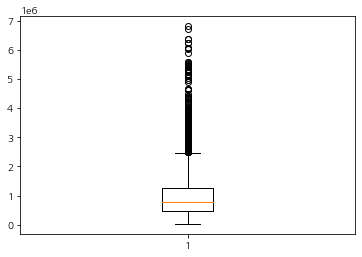

In [11]:
######Passengers 데이터 요약######

#Passengers의 요약통계량
Passengers.describe()

#승객 수의 상자그림
plt.boxplot(Passengers.PCount)

#평균 승객 수 => 1034625
sql = """SELECT AVG(P.PCount) AVGPassengers
        FROM Station S
        JOIN Passengers P
        ON S.StationID = P.StationID"""

c.execute(sql)
c.fetchall()

#평균 승객 수보다 승객이 많은 호선
sql = """SELECT S.LINE, AVG(P.PCount) AVGPassengers
        FROM Station S
        JOIN Passengers P
        ON S.StationID = P.StationID
        GROUP BY S.Line
        HAVING AVGPassengers >= 1034625"""

c.execute(sql)
c.fetchall() # 1, 2, 3, 4호선은 승객이 많이 탄다.

##########################

         FineDust  CarbonDioxide  Formaldehyde  CarbonMonoxide
count  254.000000     254.000000    254.000000      254.000000
mean    66.042520     549.688976      7.103543        0.727559
std     25.288442      85.605087      4.082289        0.262453
min     20.000000     419.000000      1.400000        0.300000
25%     48.850000     494.250000      4.625000        0.500000
50%     63.850000     532.500000      6.100000        0.700000
75%     78.850000     588.500000      8.675000        0.800000
max    155.300000     932.000000     33.600000        2.200000


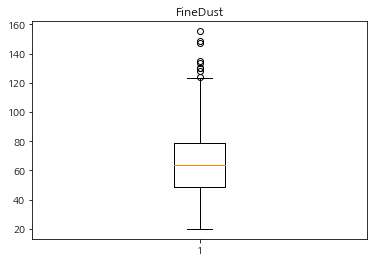

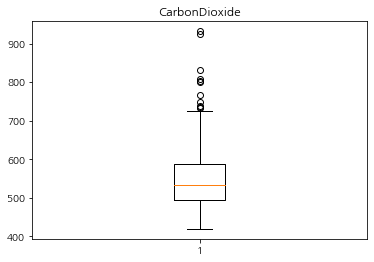

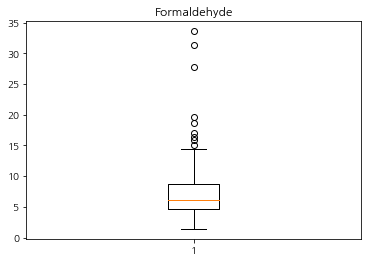

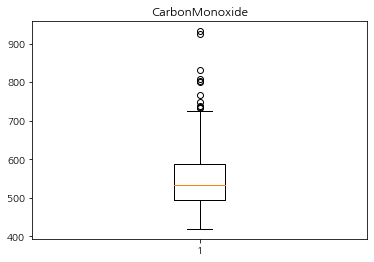

[('1호선', 0.82), ('5호선', 0.9725490196078433)]

In [17]:
#####AirQuality 데이터 요약#####

#AirQuality의 요약통게량
print(AirQuality.describe())

#지표별 상자그림
plt.boxplot(AirQuality.FineDust)
plt.title("FineDust")
plt.show()

plt.boxplot(AirQuality.CarbonDioxide)
plt.title("CarbonDioxide")
plt.show()

plt.boxplot(AirQuality.Formaldehyde)
plt.title("Formaldehyde")
plt.show()

plt.boxplot(AirQuality.CarbonDioxide)
plt.title("CarbonMonoxide")
plt.show()

##미세먼지 농도가 평균이상인 호선 구하기
#평균 미세먼지 농도
AirQuality.FineDust.mean() #66.04

#평균 미세먼지 농도보다 높은 호선
sql = """SELECT S.Line, AVG(A.FineDust) AVGDust
        FROM Station S
        JOIN AirQuality A
        ON S.StationID = A.StationID
        GROUP BY S.Line
        HAVING AVGDust > 66.04"""
c.execute(sql)
c.fetchall()


##이산화탄소 농도가 평균이상인 호선 구하기
#평균 이산화탄소 농도
AirQuality.CarbonDioxide.mean() #550

#평균 이산화탄소 농도보다 높은 호선
sql = """SELECT S.Line, AVG(A.CarbonDioxide) AVGCO2
        FROM Station S
        JOIN AirQuality A
        ON S.StationID = A.StationID
        GROUP BY S.Line
        HAVING AVGCO2 > 550"""
c.execute(sql)
c.fetchall()


##포름알데히드 농도가 평균이상인 호선 구하기
#평균 포름알데히드 농도
AirQuality.Formaldehyde.mean() #7.1

#평균 포름알데히드 농도보다 높은 호선
sql = """SELECT S.Line, AVG(A.Formaldehyde) AVGForm
        FROM Station S
        JOIN AirQuality A
        ON S.StationID = A.StationID
        GROUP BY S.Line
        HAVING AVGForm > 7.1"""
c.execute(sql)
c.fetchall()

##일산화탄소 농도가 평균이상인 호선 구하기
#평균 일산화탄소 농도
AirQuality.CarbonMonoxide.mean() #0.7275

#평균 일산화탄소 농도보다 높은 호선
sql = """SELECT S.Line, AVG(A.CarbonMonoxide) AVGCO
        FROM Station S
        JOIN AirQuality A
        ON S.StationID = A.StationID
        GROUP BY S.Line
        HAVING AVGCO > 0.7275"""
c.execute(sql)
c.fetchall()

##############################################

##############################################################################

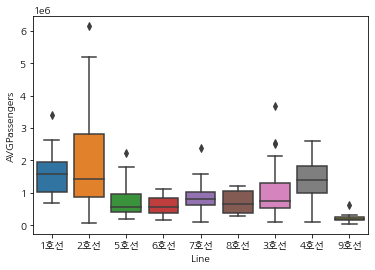

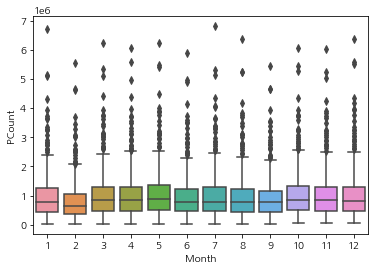

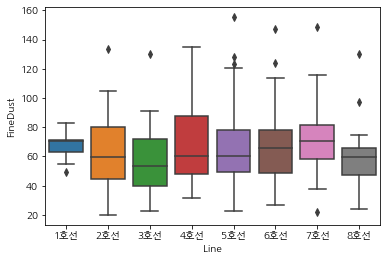

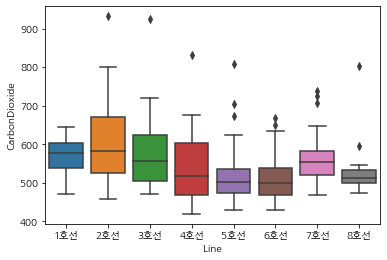

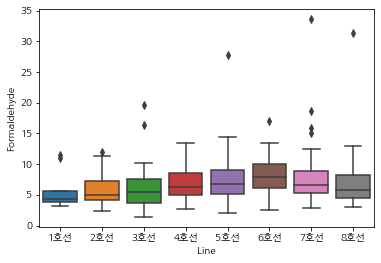

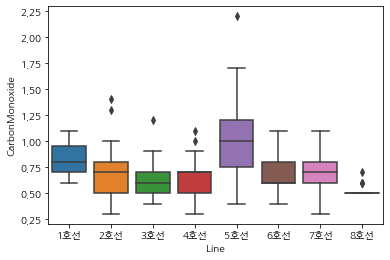

C:\Users\kw102\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,FineDust,CarbonDioxide,Formaldehyde,CarbonMonoxide
FineDust,1.000000,0.213432,0.203924,0.091755
CarbonDioxide,0.213432,1.000000,0.152869,0.035304
Formaldehyde,0.203924,0.152869,1.000000,0.236049
CarbonMonoxide,0.091755,0.035304,0.236049,1.000000


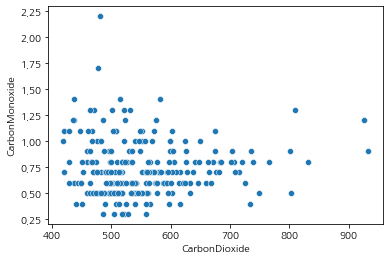

In [13]:
###################################데이터 분석#####################################

####월별 / 호선별 / 방학기간별 승객수의 차이 분석####

##1) 호선별 승객수 분석

#DB에서 역별 월평균 승객수 추출
sql = """SELECT S.StationID, S.Name, S.Line, AVG(P.PCount) AVGPassengers
        FROM Station S
        JOIN Passengers P
        ON S.StationID = P.StationID
        GROUP BY P.StationID"""

c.execute(sql)
AVGP = pd.DataFrame(c.fetchall()) #가져온 데이터 저장
AVGP.columns = ['StationID', 'Name', 'Line', 'AVGPassengers']

#호선별 승객수 boxplot 확인
sns.boxplot(x = 'Line',y = 'AVGPassengers', data = AVGP)
plt.show()

#호선별 승객수의 평균이 차이가 있는지 검정(ANOVA)

model = ols('AVGPassengers ~ Line', data = AVGP).fit()
anova_lm(model)  #*유의수준 0.05에서 p-value < 0.05이므로, 영가설 H0 : 호선별 평균 승객수는 같다를 기각한다.
                 #*호선별 승객수는 같다고 할 수 없다.

    
##2) 월별 승객수 분석

#월별 승객수 boxplot 확인
sns.boxplot(x = 'Month', y = 'PCount', data = Passengers)
plt.show()

#월별 승객수의 평균이 차이가 있는지 검정(ANOVA)

model = ols('PCount ~ Month', data = Passengers).fit()
anova_lm(model)
                #* p-value > 0.05이므로, 영가설을 기각하지 못한다.
                #* 따라서 월별 승객수는 같다고 할 수 있다.
        
        
#방학 기간과 비방학 기간(1,2, 8,9월 -> 방학)별 평균의 차이가 있는지 검정(t test)

#방학일 경우 vaction은 1, 아니면 0을 반환하는 함수
def is_vacation(month):
    if(month in [1, 2, 8 ,9]):
        return True
    else:
        return False

#모든 월에 대해 방학인지 아닌지 판별하는 Vacation 속성 생성
Passengers['Vacation'] = Passengers['Month'].apply(lambda x : is_vacation(x))

#방학 / 비방학별 승객의 평균
Passengers['PCount'].groupby(Passengers['Vacation']).mean() # 10%정도 방학일때 승객이 적다

#두 개의 집단의 평균이 같은지 검정(ttest) 
ttest_ind(Passengers[Passengers.Vacation == False].PCount, 
          Passengers[Passengers.Vacation == True].PCount)
                      #* P-vaule < 0.05로 H0 : 두 모평균이 같다 를 기각한다
                      #* 즉 방학일 때와 비방학일 때 승객의 수가 유의한 차이가 있다고 할 수 있다.

        
###호선별 / 구별 대기상태 분석####


##1) 호선별 대기상태 확인

#역 정보와 대기상태 JOIN
sql = """SELECT S.Name, S.Line, A.FineDust, A.CarbonDioxide, A.Formaldehyde, A.CarbonMonoxide
        FROM Station S
        JOIN AirQuality A
        ON S.StationID = A.StationID"""

c.execute(sql)
Air = pd.DataFrame(c.fetchall())
Air.columns = ['Name', 'Line', "FineDust", 'CarbonDioxide', 'Formaldehyde', 'CarbonMonoxide']

#호선별 대기상태 boxplot (CO2와 CO가 호선에 따라 다르게 보인다)
#호선별 미세먼지 상자그림
sns.boxplot(x = 'Line', y = 'FineDust', data = Air)
plt.show()
#호선별 CO2 상자그림
sns.boxplot(x = 'Line', y = 'CarbonDioxide', data = Air)
plt.show()
#호선별 포름알데히드 상자그림
sns.boxplot(x = 'Line', y = 'Formaldehyde', data = Air)
plt.show()
#호선별 CO 상자그림
sns.boxplot(x = 'Line', y = 'CarbonMonoxide', data = Air)
plt.show()


#호선별 각 대기품질 지표 anova
model = ols('FineDust ~ Line', data = Air).fit()
anova_lm(model)

model = ols('CarbonDioxide ~ Line', data = Air).fit()
anova_lm(model)

model = ols('Formaldehyde ~ Line', data = Air).fit()
anova_lm(model)

model = ols('CarbonMonoxide ~ Line', data = Air).fit()
anova_lm(model)
#* boxplot에서 보이는 것처럼 Co2와 CO의 p-value < 0.05로 호선별 평균이 같다고 할 수 없다.
#* 따라서 호선별로 CO2와 CO농도의 차이가 있다.


#이산화탄소 농도와 일산화탄소 농도의 관계
sns.scatterplot(Air.CarbonDioxide, Air.CarbonMonoxide, data = Air) #산점도로는 둘이 관계가 없어보인다.

#각 지표간 상관계수 행렬 
Air.iloc[:, 2:7].corr(method = 'pearson')#상관계수가 0.2이하인것으로 보아 서로 상관관계가 없다고 할 수 있다.


####################################################################################